In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD, KNNBasic, NormalPredictor, BaselineOnly, NMF
from surprise.model_selection import cross_validate, KFold, GridSearchCV
from collections import defaultdict
from surprise.prediction_algorithms import NormalPredictor, BaselineOnly, SVD, KNNBasic, NMF
from sklearn.model_selection import train_test_split as sklearn_train_test_split
from surprise.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

plt.rcParams['font.family'] = 'Times New Roman'

# Preparacion de datos

In [33]:
df_ratings = pd.read_csv('./datos/rating_final.csv')
df_places = pd.read_csv('./datos/geoplaces2.csv')

datasets_locales = ['./datos/chefmozaccepts.csv', './datos/chefmozcuisine.csv', './datos/chefmozhours4.csv', './datos/chefmozparking.csv']

for dataset in datasets_locales:
    df_temp = pd.read_csv(dataset)
    merged_places = pd.merge(df_places, df_temp, on='placeID', how='left')

print(f"Shape del DataFrame original de locales: {merged_places.shape}")

merged_places = df_places.drop_duplicates(subset=['placeID'])

merged_places.to_csv('./datos/dataLocal.csv', sep=';', index=False)

for dataset in datasets_locales:
    df_temp = pd.read_csv(dataset)
    df_places = pd.merge(df_places, df_temp, on='placeID', how='left')

avg_ratings = df_ratings.groupby('placeID')[['rating', 'food_rating', 'service_rating']].mean().reset_index()

df_places = pd.merge(df_places, avg_ratings, on='placeID', how='left')
df_places = df_places.drop_duplicates(subset=['placeID'])
df_places.to_csv('./datos/dataLocal_with_averages.csv', sep=';', index=False)

print(f"Shape del DataFrame final de locales con promedios: {df_places.shape}")

Shape del DataFrame original de locales: (130, 22)
Shape del DataFrame final de locales con promedios: (130, 29)


In [34]:
userprofile_file = './datos/userprofile.csv'
usercuisine_file = './datos/usercuisine.csv'
userpayment_file = './datos/userpayment.csv'

df_userprofile = pd.read_csv(userprofile_file, sep=',')
df_usercuisine = pd.read_csv(usercuisine_file, sep=',')
df_userpayment = pd.read_csv(userpayment_file, sep=',')

df_users = pd.merge(df_userprofile, df_usercuisine, on='userID', how='left')
df_users = pd.merge(df_users, df_userpayment, on='userID', how='left')

df_users = df_users.drop_duplicates(subset=['userID'])

avg_user_ratings = df_ratings.groupby('userID')[['rating', 'food_rating', 'service_rating']].mean().reset_index()

df_users = pd.merge(df_users, avg_user_ratings, on='userID', how='left')

df_users.to_csv('./datos/dataUser.csv', sep=';', index=False)

print(f"Shape del DataFrame original de usuarios: {df_users.shape}")

Shape del DataFrame original de usuarios: (138, 24)


In [35]:
ratings = df_users
locales = df_places

In [36]:
print(ratings.columns)
print(locales.columns)

Index(['userID', 'latitude', 'longitude', 'smoker', 'drink_level',
       'dress_preference', 'ambience', 'transport', 'marital_status', 'hijos',
       'birth_year', 'interest', 'personality', 'religion', 'activity',
       'color', 'weight', 'budget', 'height', 'Rcuisine', 'Upayment', 'rating',
       'food_rating', 'service_rating'],
      dtype='object')
Index(['placeID', 'latitude', 'longitude', 'the_geom_meter', 'name', 'address',
       'city', 'state', 'country', 'fax', 'zip', 'alcohol', 'smoking_area',
       'dress_code', 'accessibility', 'price', 'url', 'Rambience', 'franchise',
       'area', 'other_services', 'Rpayment', 'Rcuisine', 'hours', 'days',
       'parking_lot', 'rating', 'food_rating', 'service_rating'],
      dtype='object')


# Similitud del coseno

In [37]:
df_ratings = pd.read_csv('./datos/dataRatings.csv', delimiter=';')

df_ratings = df_ratings.drop_duplicates(subset=['userID', 'placeID'])

df_ratings.to_csv('./datos/dataRatings.csv', index=False, sep=';')

In [38]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics.pairwise import cosine_similarity

categorical_features = ['alcohol', 'smoking_area', 'dress_code', 'accessibility', 'price', 'Rambience', 'franchise', 'area', 'other_services', 'Rpayment', 'Rcuisine']
numerical_features = ['latitude', 'longitude', 'rating', 'food_rating', 'service_rating']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
locales_preprocessed = pipeline.fit_transform(locales)

similarity_matrix = cosine_similarity(locales_preprocessed, locales_preprocessed)

print(similarity_matrix)

[[1.         0.29052311 0.26067155 ... 0.43389833 0.7050241  0.17912732]
 [0.29052311 1.         0.62682767 ... 0.13611863 0.49574583 0.57941364]
 [0.26067155 0.62682767 1.         ... 0.22696956 0.15812585 0.33536408]
 ...
 [0.43389833 0.13611863 0.22696956 ... 1.         0.51621685 0.15246621]
 [0.7050241  0.49574583 0.15812585 ... 0.51621685 1.         0.43144178]
 [0.17912732 0.57941364 0.33536408 ... 0.15246621 0.43144178 1.        ]]


In [39]:
def recommend_locales_based_on_similarity(local_input, n=15):
    try:
        local_index = locales.loc[locales.name == local_input].index[0]
    except IndexError:
        return "Local no encontrado. Asegúrate de que el nombre sea correcto."

    similarity_score = list(enumerate(similarity_matrix[local_index]))
    similarity_score = sorted(similarity_score, key=lambda x: x[1], reverse=True)
    similarity_score = similarity_score[1:n+1]
    local_indices = [i[0] for i in similarity_score]

    return locales[['name', 'address', 'city', 'rating', 'food_rating', 'service_rating']].iloc[local_indices]

recomendaciones = recommend_locales_based_on_similarity('carnitas_mata', n=15)
print(recomendaciones)

                                    name  \
522            Hamburguesas Valle Dorado   
639                    Hamburguesas saul   
57             Abondance Restaurante Bar   
645                      Rincon Huasteco   
669                         Cafe Chaires   
705                 Restaurant Orizatlan   
898                     sirloin stockade   
330                            Luna Cafe   
441                           Potzocalli   
354                          el pueblito   
261      Restaurante la Estrella de Dima   
465  Restaurante El Chivero S.A. de C.V.   
531                          dairy queen   
54                        Restaurante 75   
3                        puesto de tacos   

                                      address             city    rating  \
522                                 Av. Coral  San Luis Potosi  0.800000   
639  Av. Saan Luis enttre moctezuma y salinas  San Luis Potosi  0.600000   
57                Industrias 908 Valle Dorado  San Luis Potosi  0.5

# SR usando Surprise

In [40]:
print(df_ratings)

     userID  placeID  rating  food_rating  service_rating   latitude  \
0     U1077   135085       2            2               2  22.150802   
1     U1077   135038       2            2               1  22.155651   
2     U1077   132825       2            2               2  22.147392   
3     U1077   135060       1            2               2  22.156883   
4     U1068   135104       1            1               2  23.752982   
...     ...      ...     ...          ...             ...        ...   
1156  U1043   132630       1            1               1  23.752931   
1157  U1011   132715       1            1               0  23.732423   
1158  U1068   132733       1            1               0  23.752707   
1159  U1068   132594       1            1               1  23.752168   
1160  U1068   132660       0            0               0  23.752943   

       longitude                                     the_geom_meter  \
0    -100.982680  0101000020957F00009F823DA6094858C18A2D4D37F9A4

In [41]:
from surprise import Dataset
from surprise import Reader

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_ratings[['userID', 'placeID', 'rating']], reader)

In [42]:
from surprise import SVD
from surprise.model_selection import cross_validate

svd = SVD(verbose=True, n_epochs=10)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.7190  0.7230  0.7308  0.7243  0.0049  
MAE (testset)     0.6147  0.6143  0.6253  0.6181  0.0051  
Fit time          0.01    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    


{'test_rmse': array([0.71899549, 0.72301997, 0.73081863]),
 'test_mae': array([0.61470442, 0.6143286 , 0.6253304 ]),
 'fit_time': (0.006574153900146484,
  0.0031540393829345703,
  0.003481149673461914),
 'test_time': (0.0015361309051513672,
  0.0014159679412841797,
  0.0018391609191894531)}

In [43]:
trainset = data.build_full_trainset()
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9


In [44]:
svd.predict(uid=10, iid=100)

Prediction(uid=10, iid=100, r_ui=None, est=1.1998277347114557, details={'was_impossible': False})

In [45]:
print(df_ratings)

     userID  placeID  rating  food_rating  service_rating   latitude  \
0     U1077   135085       2            2               2  22.150802   
1     U1077   135038       2            2               1  22.155651   
2     U1077   132825       2            2               2  22.147392   
3     U1077   135060       1            2               2  22.156883   
4     U1068   135104       1            1               2  23.752982   
...     ...      ...     ...          ...             ...        ...   
1156  U1043   132630       1            1               1  23.752931   
1157  U1011   132715       1            1               0  23.732423   
1158  U1068   132733       1            1               0  23.752707   
1159  U1068   132594       1            1               1  23.752168   
1160  U1068   132660       0            0               0  23.752943   

       longitude                                     the_geom_meter  \
0    -100.982680  0101000020957F00009F823DA6094858C18A2D4D37F9A4

In [46]:
df_ratings.loc[df_ratings.name.str.contains('Tortas Locas Hipocampo'), :]

,userID,placeID,rating,food_rating,service_rating,latitude,longitude,the_geom_meter,name,address,...,url,Rambience,franchise,area,other_services,Rpayment,Rcuisine,hours,days,parking_lot
0,U1077,135085,2,2,2,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,...,?,familiar,f,closed,none,cash,Fast_Food,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;,public
68,U1108,135085,1,2,1,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,...,?,familiar,f,closed,none,cash,Fast_Food,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;,public
211,U1081,135085,1,2,1,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,...,?,familiar,f,closed,none,cash,Fast_Food,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;,public
246,U1056,135085,2,2,2,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,...,?,familiar,f,closed,none,cash,Fast_Food,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;,public
257,U1134,135085,2,1,2,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,...,?,familiar,f,closed,none,cash,Fast_Food,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;,public
347,U1116,135085,2,2,2,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,...,?,familiar,f,closed,none,cash,Fast_Food,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;,public
403,U1132,135085,2,2,2,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,...,?,familiar,f,closed,none,cash,Fast_Food,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;,public
420,U1120,135085,0,0,0,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,...,?,familiar,f,closed,none,cash,Fast_Food,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;,public
450,U1036,135085,2,2,2,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,...,?,familiar,f,closed,none,cash,Fast_Food,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;,public
485,U1084,135085,2,2,2,22.150802,-100.98268,0101000020957F00009F823DA6094858C18A2D4D37F9A4...,Tortas Locas Hipocampo,Venustiano Carranza 719 Centro,...,?,familiar,f,closed,none,cash,Fast_Food,00:00-00:00;,Mon;Tue;Wed;Thu;Fri;,public


# Generando recomendaciones

In [47]:
import difflib
import random

def get_local_id(nombre_local, metadata):
    
    existing_names = list(metadata['name'].values)
    closest_names = difflib.get_close_matches(nombre_local, existing_names)
    place_id = metadata[metadata['name'] == closest_names[0]]['placeID'].values[0]
    return place_id

def get_local_info(local_id, metadata):
    
    local_info = metadata[metadata['placeID'] == local_id][['id', 'latitude', 
                                                    'longitude', 'address']]
    return local_info.to_dict(orient='records')

def predict_review(userID, local_name, model, metadata):
    
    placeID = get_local_id(local_name, metadata)
    review_prediction = model.predict(uid=userID, iid=placeID)
    return review_prediction.est

def generate_recommendation(userID, model, metadata, thresh=4):
    
    local_names = list(metadata['name'].values)
    random.shuffle(local_names)
    
    for local_name in local_names:
        rating = predict_review(userID, local_name, model, metadata)
        if rating >= thresh:
            placeID = get_local_id(local_name, metadata)
            return get_local_info(placeID, metadata)

In [48]:
generate_recommendation('U1103', svd, locales, 4.8)

# TSNE

In [49]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_iter=500, verbose=3, random_state=1)
locales_embedding = tsne.fit_transform(svd.qi)
projection = pd.DataFrame(columns=['x', 'y'], data=locales_embedding)
projection['nombreGenerado'] = locales['name']

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 130 samples in 0.002s...
[t-SNE] Computed neighbors for 130 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 130 / 130
[t-SNE] Mean sigma: 0.340636
[t-SNE] Computed conditional probabilities in 0.012s
[t-SNE] Iteration 50: error = 65.2019043, gradient norm = 0.5178632 (50 iterations in 0.242s)
[t-SNE] Iteration 100: error = 72.0670242, gradient norm = 0.4796251 (50 iterations in 0.025s)
[t-SNE] Iteration 150: error = 68.9939270, gradient norm = 0.5036790 (50 iterations in 0.026s)
[t-SNE] Iteration 200: error = 68.3035431, gradient norm = 0.9036630 (50 iterations in 0.024s)
[t-SNE] Iteration 250: error = 63.6606064, gradient norm = 0.9610781 (50 iterations in 0.025s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.660606
[t-SNE] Iteration 300: error = 1.1925300, gradient norm = 0.0091300 (50 iterations in 0.024s)
[t-SNE] Iteration 350: error = 1.0223398, gradient norm = 0.0078065 (

In [50]:
import plotly.express as px
import datapane as dp

fig = px.scatter(
    projection, x='x', y='y'
)
fig.show()

report = dp.Report(dp.Plot(fig) )

In [51]:
from collections import defaultdict
from surprise import Dataset, SVD

def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [52]:
algo = SVD()
algo.fit(trainset)

In [53]:
locales_visitados_usuario=df_ratings.loc[(df_ratings.userID=='U1077'),'placeID']
locales_no_visitados_usuario=df_ratings.loc[~df_ratings.placeID.isin(locales_visitados_usuario),'placeID'].unique()

pred=[]
for local in locales_no_visitados_usuario:
    pred.append(svd.predict(uid='U1077', iid=local))

In [54]:
pred

[Prediction(uid='U1077', iid=135104, r_ui=None, est=1.1916909001291283, details={'was_impossible': False}),
 Prediction(uid='U1077', iid=132740, r_ui=None, est=1.1828408230965723, details={'was_impossible': False}),
 Prediction(uid='U1077', iid=132663, r_ui=None, est=1.1247909770465814, details={'was_impossible': False}),
 Prediction(uid='U1077', iid=132732, r_ui=None, est=1.2340521365990846, details={'was_impossible': False}),
 Prediction(uid='U1077', iid=132630, r_ui=None, est=1.3006094835627149, details={'was_impossible': False}),
 Prediction(uid='U1077', iid=132584, r_ui=None, est=1.2057335942064469, details={'was_impossible': False}),
 Prediction(uid='U1077', iid=132733, r_ui=None, est=1.2882349023688437, details={'was_impossible': False}),
 Prediction(uid='U1077', iid=132560, r_ui=None, est=1.1697006618995214, details={'was_impossible': False}),
 Prediction(uid='U1077', iid=132613, r_ui=None, est=1.21971884982658, details={'was_impossible': False}),
 Prediction(uid='U1077', iid=1

In [55]:
top_n = get_top_n(pred, n=10)
top_n

defaultdict(list,
            {'U1077': [(134986, 1.7672826247813687),
              (135108, 1.5872493008683406),
              (135025, 1.5784748355399338),
              (135028, 1.5083468689707629),
              (135026, 1.4818513177030441),
              (132755, 1.4723654772865782),
              (132667, 1.4646596256738484),
              (132846, 1.45621139294436),
              (135055, 1.4465915785481633),
              (132958, 1.4444136230585618)]})

In [56]:
for uid, user_ratings in top_n.items():
    print([locales.loc[locales.placeID==iid,'name'].values[0] for (iid, _) in user_ratings])

['Restaurant Las Mananitas', 'Potzocalli', 'El Rincon de San Francisco', 'La Virreina', 'la Cantina', 'La Estrella de Dimas', 'little pizza Emilio Portes Gil', 'el lechon potosino ', 'la Cochinita Pibil Restaurante Yucateco', 'tacos los volcanes']


# Comparacion desempeño algoritmos

In [57]:
ratings_data_f = df_ratings.sample(n=100000, replace=True)
ratings_data_f = ratings_data_f[['userID', 'placeID', 'rating', 'food_rating', 'service_rating']]
reader = Reader(rating_scale=(0, 2))

In [58]:
def evaluate(data_train, algo):
    cv_results = cross_validate(algo, data_train, measures=['RMSE'], cv=4, verbose=False, n_jobs=-1)
    return round(cv_results['test_rmse'].mean(), 3)

In [59]:
def precision_recall_at_k(predictions, k=10, threshold=2.0):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls

In [60]:
def evaluate_precision_recall(data_train, algo):
    kf = KFold(n_splits=4)
    precision = []
    recall = []
    for trainset, testset in kf.split(data_train):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=10, threshold=2.0)
        precision.append(sum(prec for prec in precisions.values()) / len(precisions))
        recall.append(sum(rec for rec in recalls.values()) / len(recalls))
    return sum(precision) / len(precision), sum(recall) / len(recall)

In [61]:
algorithms = {
    'Random': (NormalPredictor, {}),
    'Baseline': (BaselineOnly, {}),
    'SVD': (SVD, {'n_factors': [50, 100], 'reg_all': [0.02, 0.05]}),
    'KNN_cosine': (KNNBasic, {'k': [20, 30], 'sim_options': {'name': ['cosine'], 'user_based': [False]}}),
    'KNN_msd': (KNNBasic, {'k': [20, 30], 'sim_options': {'name': ['msd'], 'user_based': [False]}})
}

def train_test_split_custom(df, column, reader):
    train, test = sklearn_train_test_split(df[['userID', 'placeID', column]], test_size=0.20, random_state=100)
    data_train = Dataset.load_from_df(train, reader)
    return data_train, test
results_list = []

In [62]:
for column in ['rating', 'food_rating', 'service_rating']:
    print(f'Evaluating {column}...')
    data_train, test = train_test_split_custom(ratings_data_f, column, reader)

    for algo_name, (algo_class, param_grid) in algorithms.items():
        print(f'Tuning {algo_name}...')
        try:
            gs = GridSearchCV(algo_class, param_grid, measures=['rmse'], cv=4)
            gs.fit(data_train)

            best_algo = gs.best_estimator['rmse']

            rmse = evaluate(data_train, best_algo)
            precision, recall = evaluate_precision_recall(data_train, best_algo)

            results_list.append({
                'Algoritmo': algo_name,
                'RMSE CV': rmse,
                'Precision': precision,
                'Recall': recall,
                'Rating Type': column,
                'Best Params': gs.best_params['rmse']  # Add best params here
            })
        except ZeroDivisionError as e:
            print(f'Error tuning {algo_name}: {e}')

Evaluating rating...
Tuning Random...
Tuning Baseline...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Tuning SVD...
Tuning KNN_cosine...
Computing the cosine similarity matrix...
Error tuning KNN_cosine: float division
Tuning KNN_msd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix

In [63]:
results_df = pd.DataFrame(results_list)
print(results_df)

for algo_name, (algo_class, param_grid) in algorithms.items():
    filtered_results = results_df[results_df["Algoritmo"] == algo_name]
    if not filtered_results.empty:
        best_params = filtered_results.iloc[0]['Best Params']
        print(f'Best params for {algo_name}: {best_params}')
    else:
        print(f'No results found for {algo_name}')

   Algoritmo  RMSE CV  Precision    Recall     Rating Type  \
0     Random    0.997   0.424765  0.065649          rating   
1   Baseline    0.507   0.204710  0.022787          rating   
2        SVD    0.056   0.173913  0.015579          rating   
3    KNN_msd    0.000   0.804348  0.193211          rating   
4     Random    1.018   0.460819  0.067169     food_rating   
5   Baseline    0.528   0.226449  0.023091     food_rating   
6        SVD    0.055   0.244565  0.023617     food_rating   
7    KNN_msd    0.000   0.833333  0.178932     food_rating   
8     Random    1.024   0.363614  0.056554  service_rating   
9   Baseline    0.535   0.152174  0.015815  service_rating   
10       SVD    0.055   0.135870  0.012729  service_rating   
11   KNN_msd    0.000   0.768116  0.193697  service_rating   

                                          Best Params  
0                                                  {}  
1                                                  {}  
2                 {'n_fac

Computing the msd similarity matrix...
Done computing similarity matrix.
Feature importances:
food_rating: 0.0
service_rating: 0.0
rating: 2.000192713760973


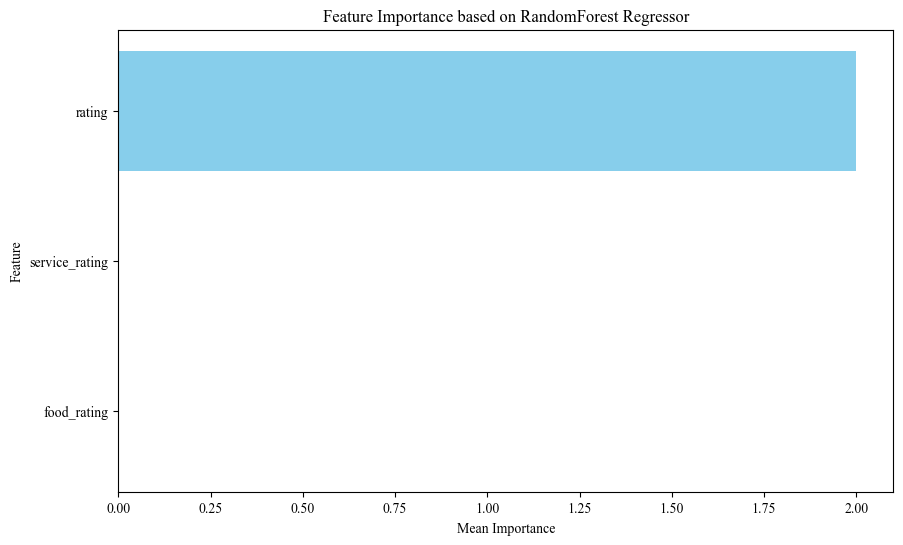

In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

ratings_data_f = df_ratings.sample(n=100000, replace=True)
ratings_data_f = ratings_data_f[['userID', 'placeID', 'rating', 'food_rating', 'service_rating']]
reader = Reader(rating_scale=(0, 2))

data = Dataset.load_from_df(ratings_data_f[['userID', 'placeID', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)

best_params_knn = {'k': 20, 'sim_options': {'name': 'msd', 'user_based': False}}
algo = KNNBasic(k=best_params_knn['k'], sim_options=best_params_knn['sim_options'])
algo.fit(trainset)

predictions = algo.test(testset)

predictions_df = pd.DataFrame([[pred.uid, pred.iid, pred.r_ui, pred.est] for pred in predictions],
                              columns=['userID', 'placeID', 'true_rating', 'pred_rating'])

merged_df = pd.merge(ratings_data_f, predictions_df[['userID', 'placeID', 'pred_rating']], on=['userID', 'placeID'])

# Seleccionar las características y la etiqueta
X = merged_df[['rating', 'food_rating', 'service_rating']]
y = merged_df['pred_rating']

model = RandomForestRegressor()
model.fit(X, y)

perm_importance = permutation_importance(model, X, y, n_repeats=10, random_state=42)

feature_names = X.columns
importances = perm_importance.importances_mean
sorted_idx = importances.argsort()

print("Feature importances:")
for i in sorted_idx:
    print(f"{feature_names[i]}: {importances[i]}")

plt.figure(figsize=(10, 6))
plt.barh(feature_names[sorted_idx], importances[sorted_idx], color='skyblue')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.title('Feature Importance based on RandomForest Regressor')
plt.show()

Computing the msd similarity matrix...
Done computing similarity matrix.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


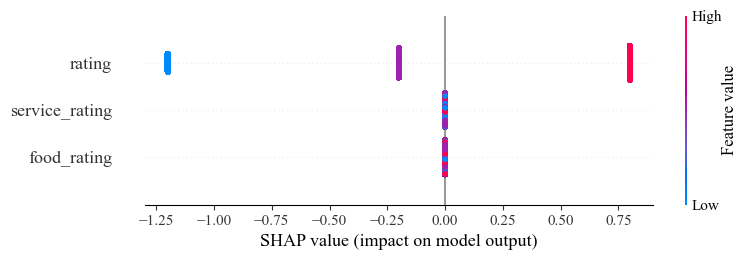

In [68]:
data = Dataset.load_from_df(ratings_data_f[['userID', 'placeID', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2)

algo = KNNBasic(k=best_params_knn['k'], sim_options=best_params_knn['sim_options'])
algo.fit(trainset)

predictions = algo.test(testset)

predictions_df = pd.DataFrame([[pred.uid, pred.iid, pred.r_ui, pred.est] for pred in predictions],
                              columns=['userID', 'placeID', 'true_rating', 'pred_rating'])

merged_df = pd.merge(ratings_data_f, predictions_df[['userID', 'placeID', 'pred_rating']], on=['userID', 'placeID'])

X = merged_df[['rating', 'food_rating', 'service_rating']]
y = merged_df['pred_rating']

model = RandomForestRegressor()
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X)